In [1]:
import pandas as pd
import numpy as np
import sys
import h5py
import yaml
import torch
from tqdm import tqdm
import importlib
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support


sys.path.append('/home/lugeon/eeg_project/scripts')
from training.dataset import datasets
from training.representation import models

import seaborn as sns
sns.set_context("paper")
sns.set(font_scale = 1.6)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

/home/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
importlib.reload(models)
importlib.reload(datasets)

<module 'training.dataset.datasets' from '/home/lugeon/eeg_project/scripts/training/dataset/datasets.py'>

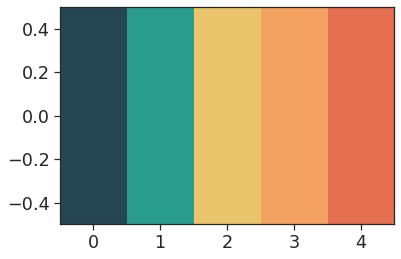

In [3]:
from matplotlib import colors
palette = ['#264653', '#2A9D8F','#E9C46A', '#F4A261', '#E76F51']
cmap = colors.ListedColormap(palette)

plt.imshow(np.arange(len(palette)).reshape(1, -1), aspect='auto', cmap=cmap,origin="lower")
plt.show()

In [71]:
device = torch.device('cpu')

result_dir = '/home/lugeon/eeg_project/scripts/training/representation/result'
#model_name = 'arch_comparison/next_frame_vgg_maxpool'
model_name = 'transformers/masked_auto_encoder'
encoder_model_dir = f'{result_dir}/{model_name}'

with open(f'{encoder_model_dir}/train_config.yaml') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)

# get model from model name
model_function = getattr(models, config['model']['name'])
model = model_function(**config['model']['kwargs'])

model.load_state_dict(torch.load(f'{encoder_model_dir}/checkpoint.pt'))

if isinstance(model, models.MaskedAutoEncoder):
    model.masking_ratio = 0.

model.to(device)
model.eval();

In [72]:
#hdf5_file = '/home/lugeon/eeg_project/dataset_healthy.h5'
hdf5_file = '/mlodata1/lugeon/dream_data/processed/healthy/dataset.h5'

dataset = datasets.EEG_Image_Batch_Dataset(hdf5_file, 
                                           window=10, 
                                           slide=5, 
                                           batch_size=128, 
                                           shuffle=True, 
                                           return_metadata=True,
                                           output_type='label')

with h5py.File(dataset.hdf5_file, 'r') as f:
    subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    
dataset

## Dream classification

In [73]:
discard_dewr = True
discard_rem = True

add_sex_age = False
add_time = True

In [75]:
loader = DataLoader(dataset, batch_size=None, shuffle=False)

encodings = []
labels = []
subject_ids = []
trial_ids = []
frame_ids = []
sleep_stages = []
elapsed_times = []

with torch.no_grad():
    for input_batch, output_batch, metadata in tqdm(loader, ncols=70):
        
        sid_batch, tid_batch, fid_batch, ss_batch, et_batch = metadata
                            
        # send to device
        input_batch = input_batch.to(device) 
                    
        # forward pass
        encoding_batch = model.encode(input_batch)
        
        if isinstance(model, models.MaskedAutoEncoder):
            encoding_batch = encoding_batch.mean(1) # mean across patches
        
        encodings.append(encoding_batch.cpu().detach().numpy())
        labels.append(output_batch.cpu().detach().numpy())
        subject_ids.append(sid_batch.cpu().detach().numpy())
        trial_ids.append(tid_batch.cpu().detach().numpy())
        trial_ids.append(fid_batch.cpu().detach().numpy())
        sleep_stages.append(ss_batch.cpu().detach().numpy())
        elapsed_times.append(et_batch.cpu().detach().numpy())
        
        del input_batch
        del output_batch
        del sid_batch
        del ss_batch
        del encoding_batch
        
x_ = np.concatenate(encodings)
y_ = np.concatenate(labels)
s_ = np.concatenate(subject_ids)
t_ = np.concatenate(trial_ids)
f_ = np.concatenate(frame_ids)
ss_ = np.concatenate(sleep_stages)
et_ = np.concatenate(elapsed_times)

100%|███████████████████████████████| 188/188 [10:09<00:00,  3.24s/it]


ValueError: need at least one array to concatenate

In [61]:
if discard_rem:
    ss_mask = (ss_ == 2) | (ss_ == 3) # Consider only NREM (1, 2, 3) or REM (4)
else:
    ss_mask = (ss_ == 2) | (ss_ == 3) | (ss_ == 4)

if discard_dewr:
    label_mask = (y_ == 0) | (y_ == 2) # Don't consider DEWR (1)
else:
    label_mask = len(y_)*[True]
    
mask = label_mask & ss_mask
y = y_[mask] 
x = x_[mask]
s = s_[mask]
t = t_[mask]
ss = ss_[mask]

y[y == 2] = 1 # Consider DEWR and DE as label 1

y.shape

(11040,)

In [62]:
if add_sex_age:
    
    df = pd.read_csv(
        '/mlodata1/lugeon/dream_data/chuv/metadata/sex_age_encoding.txt', 
        sep=' ', 
        dtype='str')
    
    map = dict(zip(
        df.id, 
        df.apply(lambda row: [int(d) for d in row.age_encoding + row.sex_encoding], 
                 axis=1)))
    
    missing_subject = set(subjects).difference(set(map.keys()))
    
    add_features = [
        map[subjects[int(id)]] if subjects[int(id)] not in missing_subject 
        else 4*[0] 
        for id in s_
        ]
    
    x_ = np.hstack((x_, add_features))
    
if add_time:
    minutes_in_a_day = 60 * 24
    et_norm = et_ * 2 * np.pi / minutes_in_a_day
    x_ = np.hstack((x_, np.cos(et_norm)[:, np.newaxis], np.sin(et_norm)[:, np.newaxis]))

/home/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


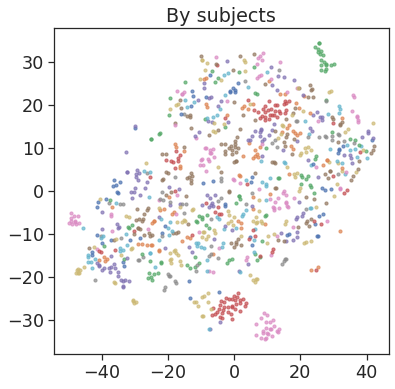

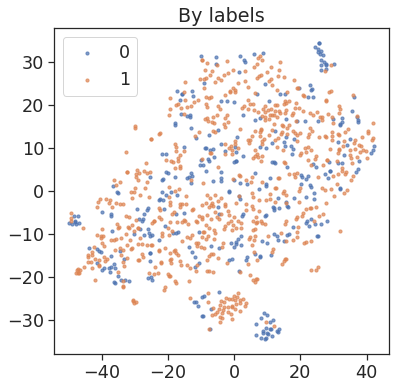

In [63]:
from sklearn.manifold import TSNE

n_samples = 1_000
sample_ix = np.random.choice(x.shape[0], n_samples, replace=False)
sampled_x = x[sample_ix]
sampled_y = y[sample_ix]
sampled_s = s[sample_ix]

reducer = TSNE(n_components=2)
projection = reducer.fit_transform(sampled_x)

fig, ax = plt.subplots(figsize=(6, 6)) 
for i, sname in enumerate(subjects):
    mask = sampled_s == i
    subject_projection = projection[mask]
    
    plt.scatter(subject_projection[:, 0], subject_projection[:, 1], s=10, alpha=0.7)
    plt.title('By subjects')
plt.show()

fig, ax = plt.subplots(figsize=(6, 6)) 
for i in [0, 1]:
    mask = sampled_y == i
    label_projection = projection[mask]
    plt.scatter(label_projection[:, 0], label_projection[:, 1], s=10, alpha=0.7, label=i)
    plt.legend()
    plt.title('By labels')

### Random splitting

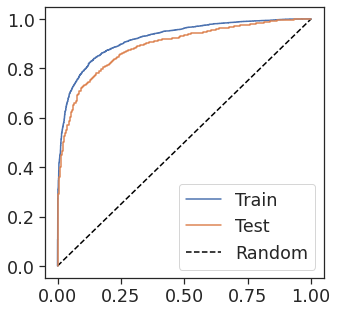

In [52]:
## Random split evaluation
fraction = 0.3

n_samples = x.shape[0]
indices = np.random.permutation(n_samples)

test_indices = indices[:int(fraction * n_samples)]
train_indices = indices[int(fraction * n_samples):]

x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

class_weight = 'balanced'
clf = LogisticRegression(max_iter=10_000, class_weight=class_weight, C=100)

clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)
y_test_score = clf.predict_proba(x_test)[:, 1]

y_train_pred = clf.predict(x_train)
y_train_score = clf.predict_proba(x_train)[:, 1]

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
acc = sum(y_test_pred == y_test) / len(y_test)

#print(f'Accuracy: {acc}')

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr_train, tpr_train, label='Train')
ax.plot(fpr_test, tpr_test, label='Test')
ax.plot([0, 1], [0, 1], label='Random', linestyle='--', color='black', zorder=0)
plt.legend()
plt.show()

In [53]:
auc(fpr_test, tpr_test), auc(fpr_train, tpr_train)

(0.8887708798696282, 0.9209202633878246)

### Trial splitting

In [57]:
minority_fraction = 0.3
run_number = 100

accs = []
accs_per_subjects = []
tprs_test = []
fprs_test = []
tprs_train = []
fprs_train = []

groupby_trials = pd.DataFrame({'sid': s, 'tid': t, 'label': y}).reset_index().groupby(['sid', 'tid'])

minority_count = groupby_trials.label.apply(lambda s: s.iloc[0]).value_counts().min()
test_class_support = int(minority_fraction * minority_count)

trial_label = groupby_trials.label.apply(lambda s: s.iloc[0]).values
video_idx = groupby_trials.index.apply(list).values
df_trials = pd.DataFrame({'label': trial_label, 'video_idx': video_idx})

neg_trial_idx = df_trials[df_trials.label == 0].index.values
pos_trial_idx = df_trials[df_trials.label == 1].index.values

for i in tqdm(range(run_number), ncols=70):

    neg_permutation = np.random.permutation(np.arange(len(neg_trial_idx)))
    pos_permutation = np.random.permutation(np.arange(len(pos_trial_idx)))

    neg_trial_idx_test = neg_trial_idx[neg_permutation[:test_class_support]]
    neg_trial_idx_train = neg_trial_idx[neg_permutation[test_class_support:]]

    pos_trial_idx_test = pos_trial_idx[pos_permutation[:test_class_support]]
    pos_trial_idx_train = pos_trial_idx[pos_permutation[test_class_support:]]

    trial_idx_test = np.concatenate((neg_trial_idx_test, pos_trial_idx_test))
    trial_idx_train = np.concatenate((neg_trial_idx_train, pos_trial_idx_train))

    train_indices = [i for ix in df_trials.iloc[trial_idx_train].video_idx.values for i in ix]
    test_indices = [i for ix in df_trials.iloc[trial_idx_test].video_idx.values for i in ix]

    x_train = x[train_indices]
    y_train = y[train_indices]
    x_test = x[test_indices]
    y_test = y[test_indices]

    class_weight = 'balanced'
    clf = LogisticRegression(C=1, max_iter=10_000, class_weight=class_weight)
    #clf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight=class_weight)

    clf.fit(x_train, y_train)
    y_test_pred = clf.predict(x_test)
    y_test_score = clf.predict_proba(x_test)[:, 1]

    y_train_pred = clf.predict(x_train)
    y_train_score = clf.predict_proba(x_train)[:, 1]

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
    acc = sum(y_test_pred == y_test) / len(y_test)
    
    correct_ix = y_test == y_test_pred
    correct_count = pd.DataFrame(s[test_indices][correct_ix], dtype=int).value_counts().sort_index()
    correct_count_ix = [i[0] for i in correct_count.index.to_numpy()]
    
    total_count = pd.DataFrame(s[test_indices], dtype=int).value_counts().sort_index()
    total_count_ix = [i[0] for i in total_count.index.to_numpy()]
    
    total_count_mapped = np.zeros(len(subjects))
    total_count_mapped[total_count_ix] = total_count.values
    correct_count_mapped = np.zeros(len(subjects))
    correct_count_mapped[correct_count_ix] = correct_count.values
    
    with np.errstate(divide='ignore', invalid='ignore'):
        accs_per_subjects.append((correct_count_mapped / total_count_mapped).tolist())
    accs.append(acc)
    tprs_test.append(tpr_test)
    fprs_test.append(fpr_test)
    tprs_train.append(tpr_train)
    fprs_train.append(fpr_train)
    
print(f'Accuracy: {np.mean(accs) * 100 :.2f} +/- {np.std(accs) * 100:.2f}')

100%|███████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]

Accuracy: 61.48 +/- 4.33


In [58]:
# precision, recall, f1 score
precision_recall_fscore_support(y_test, y_test_pred, average='binary')

(0.6341463414634146, 0.6358695652173914, 0.6350067842605156, None)

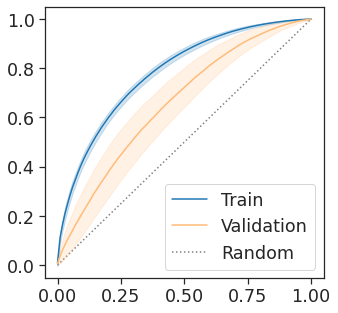

In [59]:
x_interp = np.linspace(0, 1, 100)

test_aucs = []

tprs_test_inter = []
for fpr, tpr in zip(fprs_test, tprs_test):
    tprs_test_inter.append(np.interp(x_interp, fpr, tpr).tolist())
    test_aucs.append(auc(fpr, tpr))
    
tprs_train_inter = []
for fpr, tpr in zip(fprs_train, tprs_train):
    tprs_train_inter.append(np.interp(x_interp, fpr, tpr).tolist())

tpr_train_mean = np.array(tprs_train_inter).mean(axis=0)
tpr_train_std = np.array(tprs_train_inter).std(axis=0)

tpr_test_mean = np.array(tprs_test_inter).mean(axis=0)
tpr_test_std = np.array(tprs_test_inter).std(axis=0)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x_interp, tpr_train_mean, label='Train', color=cmap(0))
ax.fill_between(x_interp, 
                tpr_train_mean - tpr_train_std, 
                tpr_train_mean + tpr_train_std, 
                color=cmap(0), alpha=0.2)

ax.plot(x_interp, tpr_test_mean, label='Validation', color=cmap(3))
ax.fill_between(x_interp, 
                tpr_test_mean - tpr_test_std, 
                tpr_test_mean + tpr_test_std, 
                color=cmap(3), alpha=0.2)

ax.plot([0, 1], [0, 1], label='Random', linestyle=':', color='grey', zorder=0)
plt.legend()
plt.show()

In [37]:
print(f'AUC-ROC: {np.mean(test_aucs) * 100 :.2f} +/- {np.std(test_aucs) * 100:.2f}')

AUC-ROC: 69.12 +/- 4.83


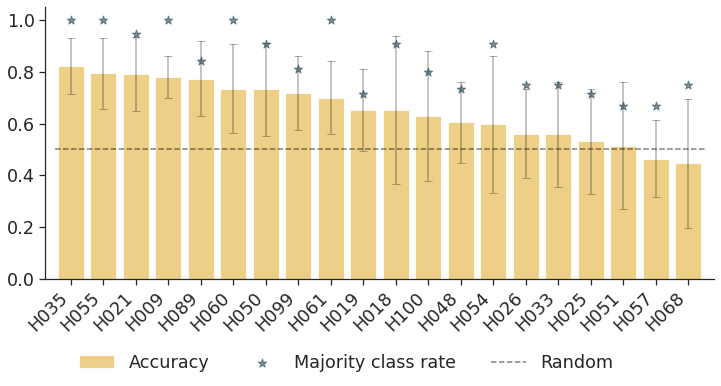

In [38]:
fig, ax = plt.subplots(figsize=(12, 5)) 

means = np.nanmean(accs_per_subjects, axis=0)
stds = np.nanstd(accs_per_subjects, axis=0)
pos_fraction_per_subjets = (
    pd.Series(s[y == 1]).value_counts().sort_index().values / 
    pd.Series(s).value_counts().sort_index()).values

maj_fraction_per_subjets = np.where(pos_fraction_per_subjets > 0.5, 
                                    pos_fraction_per_subjets, 
                                    1 - pos_fraction_per_subjets)

sort_ix = np.argsort(means)[::-1]
    
ax.bar(np.arange(len(subjects)), 
        means[sort_ix], 
        yerr=stds[sort_ix], 
        error_kw={
            'capsize': 4,
            'ecolor': 'black',
            'alpha': 0.3
        },
        color=cmap(2),
        alpha=0.8,
        zorder=1,
        label='Accuracy')

ax.scatter(np.arange(len(subjects)), 
            maj_fraction_per_subjets[sort_ix], 
            marker='*',
            s=80,
            color=cmap(0),
            alpha=0.6,
            zorder=2, 
            label='Majority class rate')

ax.plot([0 - .5, len(subjects) - .5], [.5, .5], color='black', alpha=0.5, ls='--', label='Random', zorder=3)

ax.set_xticks(np.arange(len(subjects)))
ax.set_xticklabels(np.array(subjects)[sort_ix], rotation=45, ha='right')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

ax.set_xlim([0 - .8, len(subjects) - 1 + .8])

handles, labels = plt.gca().get_legend_handles_labels()
handles_order = [2, 0, 1]

ax.legend([handles[idx] for idx in handles_order],
          [labels[idx] for idx in handles_order],
          frameon=False, ncol=3, loc='lower center', bbox_to_anchor=(0.45, -0.4))

plt.savefig('acc_per_sub.png', bbox_inches='tight')
plt.plot();

### Evaluation within subjects

In [39]:
clf = LogisticRegression(class_weight='balanced', max_iter=10_000)

s_accs = []
s_accs_label = []
for i, sname in enumerate(subjects):
    smask = s == i
    xs = x[smask]
    ys = y[smask]
    ts = t[smask]
    trials = pd.Series(ts).drop_duplicates().tolist()
    
    t_accs = []
    t_accs_label = []
    for trial in trials:
        tmask = ts == trial
        x_test = xs[tmask]
        y_test = ys[tmask]
        x_train = xs[~tmask]
        y_train = ys[~tmask]
        
        if (sum(y_train) == len(y_train)) or (sum(1 - y_train) == len(y_train)):
            continue

        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        acc = sum(y_test == y_pred) / len(y_test)
        t_accs.append(acc)
        t_accs_label.append(y_test[0])
        
    s_accs.append(t_accs)
    s_accs_label.append(t_accs_label)

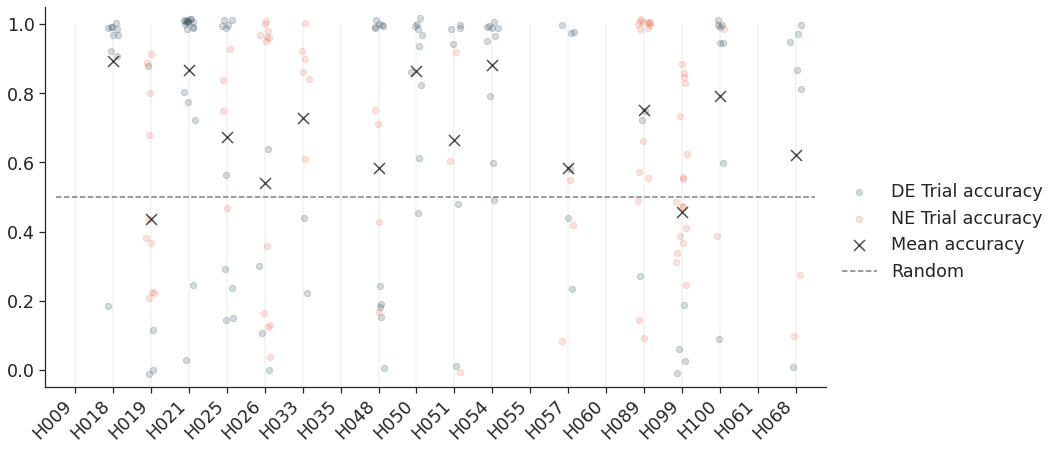

In [40]:
fig, ax = plt.subplots(figsize=(14, 7)) 
    
legend_ne = False
legend_de = False
legend_mean = False

i = 0
for t_accs, t_accs_label in zip(s_accs, s_accs_label):
    for j, acc, t_acc_label in zip(np.arange(len(t_accs)), t_accs, t_accs_label):
        
        rx = (np.random.random() - 0.5) / 3 
        ry = (np.random.random() - 0.5) / 3 / 10
        if (t_acc_label == 0) and not legend_ne: label = 'NE Trial accuracy'; legend_ne = True
        elif (t_acc_label == 1) and not legend_de: label = 'DE Trial accuracy'; legend_de = True
        else: label = None
        if t_acc_label == 0: color = cmap(4)
        else: color = cmap(0)
        plt.scatter(i + rx, acc+ry, color = color, marker='o', alpha=0.2, s=40, label=label)
        
    if len(t_accs) > 0:
        if (not legend_mean) and i > 5: label = 'Mean accuracy'; legend_mean = True
        else: label = None
        ax.scatter(i, np.mean(t_accs), color = 'black', marker='x', alpha=0.7, s=120, label=label)
    ax.plot([i, i], [-0.05, 1], color='grey', alpha=0.1, zorder=0)
        
    i += 1

ax.plot([0 - .5, len(subjects) - .5], [.5, .5], color='black', alpha=0.5, ls='--', label='Random', zorder=0)

ax.set_xticks(np.arange(len(subjects)))
ax.set_xticklabels(subjects, rotation=45, ha='right')

ax.set_ylim([-0.05, 1.05])
ax.set_xlim([0 - .8, len(subjects) - 1 + .8])

plt.legend(bbox_to_anchor=[1, .58], frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

plt.savefig('img/within_subject_pred.pdf', bbox_inches='tight')

plt.plot();

## Metrics for one subject

In [ ]:
test_subject = 1
print(f'Subject ID: {subjects[test_subject]}')
mask = s == test_subject

In [ ]:
x_train = x[~mask]
y_train = y[~mask]

x_test = x[mask]
y_test = y[mask]

In [ ]:
pd.DataFrame(y_train).value_counts() # training distribution

In [ ]:
pd.DataFrame(y_test).value_counts() # testing distribution

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=5, class_weight='balanced')
forest_clf.fit(x_train, y_train)

In [ ]:
under_sample = True
if under_sample:
    under_sampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

    x_test, y_test = under_sampler.fit_resample(x_test, y_test)

In [ ]:
y_predicted = forest_clf.predict(x_test)
sum(y_test == y_predicted) / len(y_test) # accuracy

In [ ]:
cm = confusion_matrix(y_test, y_predicted, labels=forest_clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_clf.classes_)
disp.plot()
plt.show()

In [ ]:
y_score = forest_clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig, ax = plt.subplots(figsize=(5, 5)) 

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], label='baseline', linestyle='--', color='grey')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Leave-one-subject-out evaluation

In [41]:
def compute_metrics(encodings, labels, subject_ids, subjects_name, balanced=True):
    
    fprs, tprs, accs, snames = [], [], [], []
    
    for sid, sname in tqdm(enumerate(subjects_name), total=len(subjects_name)):
        mask = subject_ids == sid
        
        x_train = encodings[~mask]
        y_train = labels[~mask]

        x_test = encodings[mask]
        y_test = labels[mask]
        
        class_weight = None
        if balanced:
            if sum(y_test) == 0 or sum(1 - y_test) == 0:
                print(f'No evaluation for subject {sname}: data is single labelled.')
                continue
            else:
                under_sampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
                x_test, y_test = under_sampler.fit_resample(x_test, y_test)
                class_weight='balanced'
            
        clf = LogisticRegression(class_weight='balanced', max_iter=10_000)
        #clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=5)
        clf.fit(x_train, y_train)
        
        y_score = clf.predict_proba(x_test)[:, 1]
        y_pred = clf.predict(x_test)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        acc = sum(y_pred == y_test) / len(y_test)
        
        fprs.append(fpr)
        tprs.append(tpr)
        accs.append(acc)
        snames.append(sname)
        
    return fprs, tprs, accs, snames


fprs, tprs, accs, snames = compute_metrics(x, y, s, subjects, balanced=True)

  0%|          | 0/20 [00:00<?, ?it/s]

No evaluation for subject H009: data is single labelled.


 35%|███▌      | 7/20 [00:07<00:15,  1.16s/it]

No evaluation for subject H035: data is single labelled.


 60%|██████    | 12/20 [00:11<00:07,  1.07it/s]

No evaluation for subject H055: data is single labelled.


 70%|███████   | 14/20 [00:12<00:04,  1.30it/s]

No evaluation for subject H060: data is single labelled.


 90%|█████████ | 18/20 [00:15<00:01,  1.32it/s]

No evaluation for subject H061: data is single labelled.


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


In [42]:
print(f'LOSO Acc: {np.mean(accs) * 100 :.2f} +/- {np.std(accs) * 100:.2f}')

LOSO Acc: 49.61 +/- 11.21


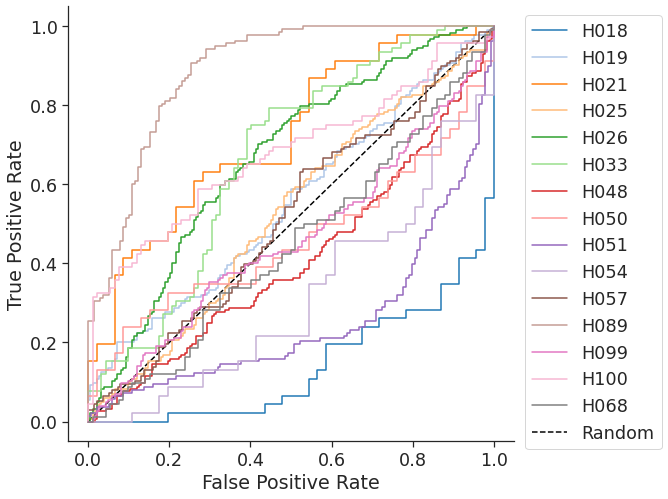

In [45]:
fig, ax = plt.subplots(figsize=(8, 8)) 
cmap = plt.get_cmap('tab20')

i = 0
for fpr, tpr, sname in zip(fprs, tprs, snames):
    if fpr is not None:
        ax.plot(fpr, tpr, label=sname, color=cmap(i))
    i += 1
    
ax.plot([0, 1], [0, 1], label='Random', linestyle='--', color='black', zorder=0)

plt.legend(bbox_to_anchor=[1.35, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('img/weighted_roc_next_frame.png', bbox_inches='tight')

plt.show()
    

In [46]:
# mean area under the ROC curve
aucs = [auc(fpr, tpr) for (fpr, tpr) in zip(fprs, tprs)]
np.mean(aucs), np.std(aucs)

(0.5123284674088078, 0.18745082226260054)